In [29]:
import pandas as pd
from PIL.ImageOps import scale

from sklearn.metrics import confusion_matrix # 混合行列
from sklearn.model_selection import train_test_split

# 図やグラフを図示するためのライブラリをインポートする。
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA #主成分分析
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier # K近傍法
from sklearn.svm import SVC # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from lightgbm import LGBMClassifier #LGBM
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.naive_bayes import GaussianNB # ナイーブ・ベイズ
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA # 二次判別分析
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier



In [30]:
# データの読み込み
data = pd.read_csv('../../data/preprocessed_data.csv')

# 特徴量とターゲット変数の分割
X = data.drop('dengue', axis=1)  
y = data['dengue']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
#最適化したハイパーパラメータの表示
best_params_df=pd.read_csv('best_params/best_hyperparameters_1.csv')
best_params_df.tail()

,Unnamed: 0,solver,C,n_neighbors,weights,algorithm,gamma,criterion,max_depth,min_samples_split,min_samples_leaf,n_estimators,num_leaves,learning_rate,var_smoothing
3,Decision Tree,NaN,NaN,NaN,NaN,NaN,NaN,gini,91.0,54.0,58.0,NaN,NaN,NaN,NaN
4,Random Forest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,3.0,47.0,272.0,NaN,NaN,NaN
5,LGBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785.0,726.0,0.011312,NaN
6,AdaBoost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,489.0,NaN,0.786966,NaN
7,Naive Bayes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.250776e-09


In [33]:
names = ["Logistic Regression", "Nearest Neighbors", "RBF SVM", 
         "Decision Tree","Random Forest","LGBM","AdaBoost", "Naive Bayes",]

classifiers = [
    LogisticRegression(solver='liblinear',penalty='l2',C=0.076352,class_weight='balanced'),
    KNeighborsClassifier(n_neighbors=95,weights='distance',algorithm='ball_tree'),
    SVC(kernel="rbf",C=14.378987,gamma='scale',class_weight='balanced'),
    DecisionTreeClassifier(criterion='gini',max_depth=91,min_samples_split=54,min_samples_leaf=58,class_weight='balanced'),
    RandomForestClassifier(max_depth=50,min_samples_split=3,min_samples_leaf=47,n_estimators=272,class_weight='balanced'),
    LGBMClassifier(n_estimators=785,num_leaves=726,learning_rate=0.011312,class_weight='balanced'),
    AdaBoostClassifier(algorithm='SAMME',n_estimators=489,learning_rate=0.786966),
    GaussianNB(var_smoothing=2.250776e-09)]

In [34]:
result = []
for name, clf in zip(names, classifiers): # 指定した複数の分類機を順番に呼び出す
    clf.fit(X_train, y_train) # 学習
    score1 = clf.score(X_train, y_train) # 正解率（train）の算出
    score2 = clf.score(X_test, y_test) # 正解率（test）の算出
    result.append([score1, score2]) # 結果の格納

# test の正解率の大きい順に並べる
result = pd.DataFrame(result, columns=['train', 'test'], index=names).sort_values('test', ascending=False)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1527, number of negative: 1981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 3508, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

<Axes: >

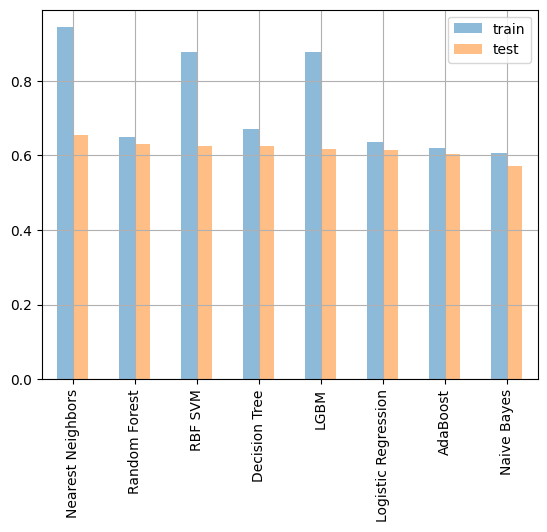

In [35]:
 #棒グラフの描画
result.plot(kind='bar', alpha=0.5, grid=True)


スタッキング

In [36]:
# 使用するモデル名と分類器を定義
names = ["Logistic Regression", "Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "LGBM", "AdaBoost", "Naive Bayes"]

classifiers = [
    LogisticRegression(solver='liblinear', penalty='l2', C=0.076352, class_weight='balanced'),
    KNeighborsClassifier(n_neighbors=95, weights='distance', algorithm='ball_tree'),
    SVC(kernel="rbf", C=14.378987, gamma='scale', class_weight='balanced'),
    DecisionTreeClassifier(criterion='gini', max_depth=91, min_samples_split=54, 
                           min_samples_leaf=58, class_weight='balanced'),
    RandomForestClassifier(max_depth=50, min_samples_split=3, min_samples_leaf=47, 
                           n_estimators=272, class_weight='balanced'),
    LGBMClassifier(n_estimators=785, num_leaves=726, learning_rate=0.011312, class_weight='balanced'),
    AdaBoostClassifier(algorithm='SAMME', n_estimators=489, learning_rate=0.786966),
    GaussianNB(var_smoothing=2.250776e-09)
]

# モデルをペアにして定義（名前と対応する分類器）
estimators = [(name, clf) for name, clf in zip(names, classifiers)]

# 最終的なメタモデルとしてロジスティック回帰を使用
meta_model = LogisticRegression()

# スタッキングの定義
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=meta_model)

# モデルのトレーニング
stacking_clf.fit(X_train, y_train)

# 予測
y_pred = stacking_clf.predict(X_test)

# 精度の表示
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")


#可視化の準備
stacking_score1 = stacking_clf.score(X_train, y_train)  # 正解率（train）
stacking_score2 = stacking_clf.score(X_test, y_test)    # 正解率（test）

# スタッキング結果を DataFrame に追加
stacking_result = pd.DataFrame([[stacking_score1, stacking_score2]], columns=['train', 'test'], index=['Stacking'])

# 既存の結果とスタッキング結果を結合
result_df = pd.concat([pd.DataFrame(result, columns=['train', 'test'], index=names), stacking_result])

# test の正解率の大きい順に並べる
result_df = result_df.sort_values('test', ascending=False)




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1527, number of negative: 1981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 3508, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

バギング

In [37]:
# モデル名と分類器を定義
names = ["Logistic Regression", "Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "LGBM", "AdaBoost", "Naive Bayes"]

classifiers = [
    LogisticRegression(solver='liblinear', penalty='l2', C=0.076352, class_weight='balanced'),
    KNeighborsClassifier(n_neighbors=95, weights='distance', algorithm='ball_tree'),
    SVC(kernel="rbf", C=14.378987, gamma='scale', class_weight='balanced'),
    DecisionTreeClassifier(criterion='gini', max_depth=91, min_samples_split=54, 
                           min_samples_leaf=58, class_weight='balanced'),
    RandomForestClassifier(max_depth=50, min_samples_split=3, min_samples_leaf=47, 
                           n_estimators=272, class_weight='balanced'),
    LGBMClassifier(n_estimators=785, num_leaves=726, learning_rate=0.011312, class_weight='balanced'),
    AdaBoostClassifier(algorithm='SAMME', n_estimators=489, learning_rate=0.786966),
    GaussianNB(var_smoothing=2.250776e-09)
]

# 各モデルに対してバギングを適用
for name, clf in zip(names, classifiers):
    # バギングの設定
    bagging_clf = BaggingClassifier(
        estimator=clf,
        n_estimators=10,  # 推定器の数
        max_samples=0.8,  # データサンプルの割合
        max_features=0.8,  # 特徴量のサンプル割合
        bootstrap=True,
        random_state=42
    )
    
    # モデルのトレーニング
    bagging_clf.fit(X_train, y_train)
    
    # 予測
    y_pred = bagging_clf.predict(X_test)
    
    # 精度の表示
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} with Bagging Accuracy: {accuracy:.4f}")


Logistic Regression with Bagging Accuracy: 0.6185
Nearest Neighbors with Bagging Accuracy: 0.6241
RBF SVM with Bagging Accuracy: 0.6241
Decision Tree with Bagging Accuracy: 0.6298
Random Forest with Bagging Accuracy: 0.6241
[LightGBM] [Info] Number of positive: 1527, number of negative: 1981
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 3508, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503829 -> initscore=0.015315
[LightGBM] [Info] Start training from score 0.015315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:704: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:704: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:704: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:704: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:704: RuntimeWarning: divide by zero encountered in log
  np.log(sample_weight)
/home/gen/anaconda3/envs/dengue/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:704: RuntimeWarni

AdaBoost with Bagging Accuracy: 0.6036
Naive Bayes with Bagging Accuracy: 0.5661


In [39]:
# 結果の表示
print(result_df)


                        train      test
Nearest Neighbors    0.943558  0.654897
Stacking             0.920468  0.645786
Random Forest        0.649373  0.630979
RBF SVM              0.878278  0.626424
Decision Tree        0.671038  0.625285
LGBM                 0.876568  0.617312
Logistic Regression  0.634835  0.613895
AdaBoost             0.620867  0.604784
Naive Bayes          0.606899  0.571754


<Axes: >

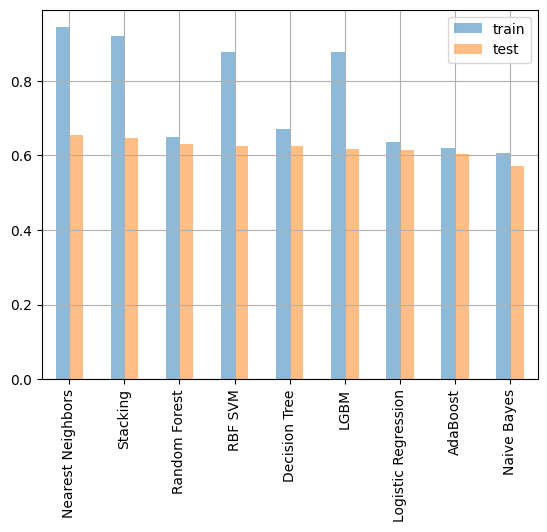

In [40]:
result_df.plot(kind='bar', alpha=0.5, grid=True)